## 🔰*============ Preprocess Data =============*🔰
  * apply normalization on the interval (0,1)

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#@title Helper Functions: view_random_augmented_images
def _get_random_images(images,labels):
  batch_size = images.shape[0]
  random_indexes = rnd.sample(range(0,batch_size),k=9)
  r_imgs = images[random_indexes,...]
  r_labels = labels[random_indexes]
  return r_imgs,r_labels

def _show_image(image,subplot):
    """
      Handles displaying an image on a specified subplot
    """
    ax = plt.subplot(subplot)
    ax.imshow(image)  
    return ax

def _format_fig(figure):
  """
    Formats subplots to reduce whitespace
  """
  figure.suptitle(f'Images of Augmented Data',
                  fontsize=12,
                  y=0.99)
  figure.tight_layout(pad=2,
                      h_pad=0.90,
                      w_pad=0.25)


def _format_ax(ax,idx,label,names):
    """
      helper function for displaying images
      hides axes ticks to reduce cluttering
    """
    #--- Format axes
    label_idx = np.where(label==1)[0][0]
    text = names[label_idx]
    ax.set_title(f'{text}')

    #--- Keep Axes ticks along edges, delete others.
    if (idx % 3):
      ax.set_yticks([])
    if (idx < 6):
      ax.set_xticks([])

def view_random_augmented_images(data,class_names):
  
  #Setup the target directory:
  target_data, target_labels = data.next()

  #get 9 random image names:
  images,labels = _get_random_images(target_data,target_labels)

  #Setup for showing images
  fig = plt.figure(figsize=(9,9))

  #Show random images
  for ax_idx, img in enumerate(zip(images,labels)):
    image, label = img
    ax = _show_image(image=image,
                     subplot=331 + ax_idx)
    #-Format:
    _format_ax(ax=ax,
               idx=ax_idx,
               label=label,
               names=class_names)
  
  #--- Add a Title
  _format_fig(figure=fig)

In [ ]:
#---Set Random Seed:
tf.random.set_seed(321)

#---Create ImageDataGenerator Instances:

#--Data should be augmented for training data, but not test data
train_IDG_aug = ImageDataGenerator(rescale = 1/255.0,
                                   rotation_range = 0.2,
                                   shear_range = 0.10,
                                   zoom_range = 0.10,
                                   channel_shift_range=0.10,
                                   width_shift_range=0.08,     
                                   height_shift_range=0.08,
                                   horizontal_flip=True,
                                   validation_split=0.20)



test_IDG_aug = ImageDataGenerator(rescale = 1/255.0)

In [ ]:
#--- Set Global Variables
IMG_SIZE = (224,224)
BATCH_SIZE = 32
SEED = 322
SHUFFLE = True
CLASS_MODE = 'categorical'

#--- Set path names:
train_folder = '10_food_classes_all_data/train'
test_folder = '10_food_classes_all_data/test'

train_data = train_IDG_aug.flow_from_directory(train_folder,
                                                   target_size=IMG_SIZE,
                                                   batch_size=BATCH_SIZE,
                                                   class_mode=CLASS_MODE,
                                                   shuffle=SHUFFLE,
                                                   subset='training',
                                                   seed=SEED)

valid_data = train_IDG_aug.flow_from_directory(train_folder,
                                                   target_size=IMG_SIZE,
                                                   batch_size=BATCH_SIZE,
                                                   class_mode=CLASS_MODE,
                                                   shuffle=SHUFFLE,
                                                   subset='validation',
                                                   seed= SEED + 1)

test_data = test_IDG_aug.flow_from_directory(test_folder,
                                             target_size=IMG_SIZE,
                                             batch_size=BATCH_SIZE,
                                             class_mode=CLASS_MODE,
                                             shuffle=SHUFFLE,
                                             seed= SEED + 2)

Found 6000 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


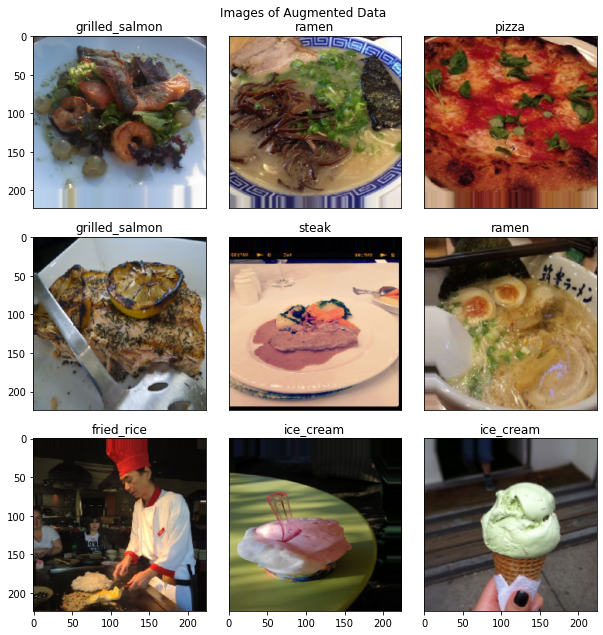

In [ ]:
view_random_augmented_images(train_data,class_names)

## 🔰============ Build Models =============🔰
* Note: Model performance **assuming random guessing** is **10% accuracy**.

In [ ]:
#@title Helper Functions: Show_Model, Training_Plot, BuildCompileFit, ContinueTraining
#---------------Build some helper functions:

def Show_Model(model,name):
    """
      Will provide a visual representation of model,
      showing layers, and input/output shapes. 
    """
    file_name = f'{name}.png'
    plot = plot_model(model,
                      to_file=file_name,
                      show_layer_activations=True,
                      show_shapes=True)
    
    plt.figure(figsize=(8,8))
    image = mpimg.imread(file_name)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])  

def _format_training_plot(fig,axL,axR):
  axL.set_title('Metrics')
  axR.set_title('Losses')

  axL.set_ylabel('Accuracy/Other')
  axR.set_ylabel('Loss')
  
  axL.set_xlabel('epochs')
  axR.set_xlabel('epochs')

  axL.legend()
  axR.legend()

  fig.suptitle('Training Results',fontsize=15,y=1.0)
  fig.tight_layout(pad=2.0,w_pad=1)

def Training_Plot(history):
  """
    Will plot results from model training:
      loss,accuracy vs epochs
  """
  fig = plt.figure(figsize=(15,4))
  axL = plt.subplot(121)
  axR = plt.subplot(122)
  for key,y in history.history.items():
    x = range(0,len(y))
    if 'loss' in key:
      axR.plot(x,y,label=key)
    else:
      axL.plot(x,y,label=key)

  _format_training_plot(fig,axL,axR)


def BuildCompileFit(trn_data,val_data,layers,loss,optimizer,callbacks,metrics,
                    rndSeed,epochs,verbose=0,show_model=False,model_name='Model'):
  
  #--- Set Random Seed
  tf.random.set_seed(rndSeed)

  #--- Build Model
  model = tf.keras.Sequential(layers)

  #--- Compile Model
  model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
  
  if show_model:
     Show_Model(model,model_name)

  #--- Fit Model:
  history=model.fit(trn_data,
                    epochs=epochs,
                    steps_per_epoch=len(trn_data),
                    callbacks=callbacks,
                    validation_data=val_data,
                    validation_steps=len(val_data),
                    verbose=verbose)


  #--- Evaluate Model
  if not verbose:
    print('\nEvaluation: ',model.evaluate(trn_data),'\n')              

  #------------------View Loss/Training Curve:
  Training_Plot(history)

  return model,history


def ContinueTraining(trn_data,val_data,model,callbacks,epochs,verbose=0):
  """
    Used to avoid recompiling a new model, 
    to continue after some initial training. 
  """

  #--- Fit Model:
  history=model.fit(trn_data,
                    epochs=epochs,
                    steps_per_epoch=len(trn_data),
                    callbacks=callbacks,
                    validation_data=val_data,
                    validation_steps=len(val_data),
                    verbose=verbose)

  #--- Evaluate Model
  if not verbose:
    print('\nEvaluation: ',model.evaluate(trn_data),'\n')              

  #------------------View Loss/Training Curve:
  Training_Plot(history)

  return model, history

In [ ]:
#--- Architecture:
INPUT_SHAPE = (224,224,3)

layers_0 = [Input(shape=INPUT_SHAPE,name='Input'),
            Conv2D(filters=10,
                   kernel_size=3,
                   padding='valid',
                   activation='leaky_relu',
                   name='Conv_1'),
            Flatten(name='Flatten_1'),
            Dense(units=10,                     # number of units, needs to match number of classes
                  activation='softmax')          
          ]

Epoch 1/10
188/188 [==============================] - 109s 526ms/step - loss: 10.9978 - accuracy: 0.1822 - val_loss: 3.2166 - val_accuracy: 0.1653
Epoch 2/10
188/188 [==============================] - 98s 524ms/step - loss: 2.4209 - accuracy: 0.2347 - val_loss: 2.2642 - val_accuracy: 0.2513
Epoch 3/10
188/188 [==============================] - 98s 522ms/step - loss: 2.1833 - accuracy: 0.2695 - val_loss: 2.2518 - val_accuracy: 0.2720
Epoch 4/10
188/188 [==============================] - 98s 521ms/step - loss: 2.1593 - accuracy: 0.2710 - val_loss: 2.3145 - val_accuracy: 0.2793
Epoch 5/10
188/188 [==============================] - 97s 517ms/step - loss: 2.1322 - accuracy: 0.2845 - val_loss: 2.2528 - val_accuracy: 0.2640
Epoch 6/10
188/188 [==============================] - 97s 514ms/step - loss: 2.1341 - accuracy: 0.2893 - val_loss: 2.0755 - val_accuracy: 0.3027
Epoch 7/10
188/188 [==============================] - 96s 514ms/step - loss: 2.1137 - accuracy: 0.2973 - val_loss: 2.2425 - val_

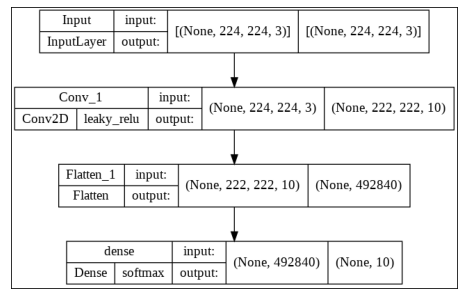

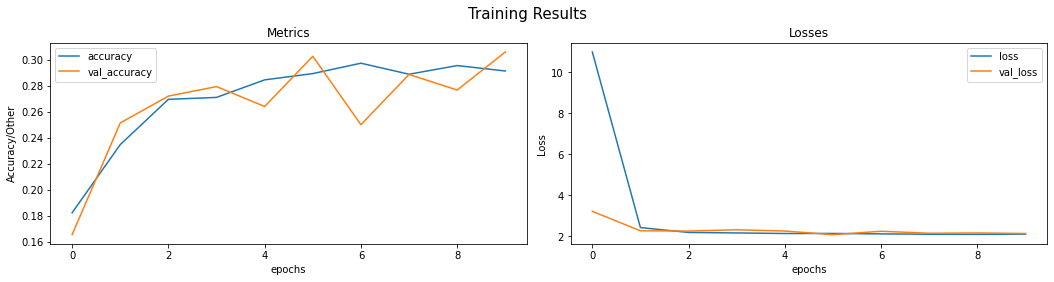

In [ ]:
#--- Build, Compile, and Fit model:
model_0,history_0 = BuildCompileFit(trn_data=train_data,
                                   val_data=valid_data,
                                   layers=layers_0,
                                   loss=tf.keras.losses.CategoricalCrossentropy(),
                                   optimizer=tf.keras.optimizers.Adam(),
                                   callbacks=None,
                                   metrics=['accuracy'],
                                   rndSeed=325,
                                   epochs=10,
                                   verbose=1,
                                   show_model=True)

In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 11s 134ms/step - loss: 2.1943 - accuracy: 0.2900


[2.1943111419677734, 0.28999999165534973]

In [ ]:
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 Flatten_1 (Flatten)         (None, 492840)            0         
                                                                 
 dense (Dense)               (None, 10)                4928410   
                                                                 
Total params: 4,928,690
Trainable params: 4,928,690
Non-trainable params: 0
_________________________________________________________________


## 🔑The model performs **better** than random guessing **30% accuracy** but is still performing poorly overall compared to the binary classification, which was able to achieve ~80% accuracy. 

## 🔑The **training** & **validation** losses are roughly the same implying that the model has not begun to overfit. However, the loss appears to have tapered and seems unlikely to benefit from extended training. A more complex model may be needed.
<br>

* ##  Note that the model also required **~5 Million parameters** to train.


In [ ]:
#--- Architecture:
INPUT_SHAPE = (224,224,3)

layers_1 = [Input(shape=INPUT_SHAPE,name='Input'),
            Conv2D(filters=50,
                   kernel_size=3,
                   padding='valid',
                   activation='leaky_relu',
                   name='Conv_1'),
            MaxPool2D(pool_size=2,
                      padding='valid',
                      name='P1'),
            Conv2D(filters=50,
                   kernel_size=3,
                   padding='valid',
                   activation='leaky_relu',
                   name='Conv_2'),
            MaxPool2D(pool_size=2,
                      padding='valid',
                      name='P2'),
            Conv2D(filters=50,
                   kernel_size=3,
                   padding='valid',
                   activation='leaky_relu',
                   name='Conv_3'),
            MaxPool2D(pool_size=2,
                      padding='valid',
                      name='P3'),
            Flatten(name='Flatten_1'),
            Dense(units=160,
                  activation='selu',
                  name='D1'),
            Dense(units=40,
                  activation='selu',
                  name='D2'),
            Dense(units=10,                     # number of units, needs to match number of classes
                  activation='softmax')          
          ]

Epoch 1/5
188/188 [==============================] - 101s 535ms/step - loss: 2.1809 - accuracy: 0.2228 - val_loss: 2.0048 - val_accuracy: 0.3093
Epoch 2/5
188/188 [==============================] - 99s 528ms/step - loss: 1.9583 - accuracy: 0.3122 - val_loss: 1.9609 - val_accuracy: 0.3087
Epoch 3/5
188/188 [==============================] - 99s 528ms/step - loss: 1.8940 - accuracy: 0.3403 - val_loss: 1.8886 - val_accuracy: 0.3473
Epoch 4/5
188/188 [==============================] - 100s 530ms/step - loss: 1.8436 - accuracy: 0.3605 - val_loss: 1.8907 - val_accuracy: 0.3580
Epoch 5/5
188/188 [==============================] - 99s 527ms/step - loss: 1.7898 - accuracy: 0.3852 - val_loss: 1.8281 - val_accuracy: 0.3853


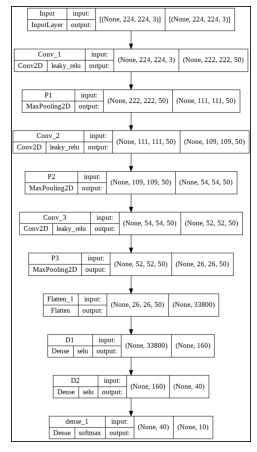

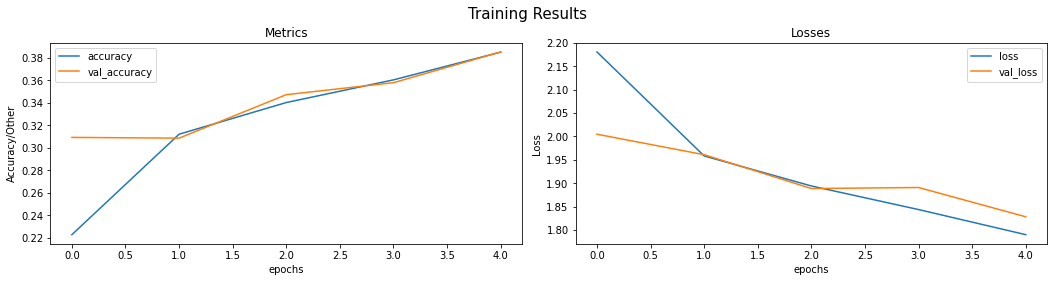

In [ ]:
#--- Build, Compile, and Fit model:
model_1,history_1 = BuildCompileFit(trn_data=train_data,
                                   val_data=valid_data,
                                   layers=layers_1,
                                   loss=tf.keras.losses.CategoricalCrossentropy(),
                                   optimizer=tf.keras.optimizers.Adam(learning_rate=10**-4),
                                   callbacks=None,
                                   metrics=['accuracy'],
                                   rndSeed=325,
                                   epochs=5,
                                   verbose=1,
                                   show_model=True)

In [ ]:
model_1.evaluate(test_data)

79/79 [==============================] - 11s 133ms/step - loss: 1.7959 - accuracy: 0.3784


[1.795856237411499, 0.3783999979496002]

### 🔑 After only **5 epochs** this model was able to achieve an **accuracy of 38%**. 
### 🔑 The **loss curves appear to be moving in tandem**, which is an excellent sign that the **model is not overfitting.** 
### 🔑  The **loss curves** have also **not tapered**, suggesting the **model will benefit from continued training.** 

Epoch 1/35
188/188 [==============================] - 101s 539ms/step - loss: 1.7515 - accuracy: 0.3925 - val_loss: 1.8223 - val_accuracy: 0.3867
Epoch 2/35
188/188 [==============================] - 100s 535ms/step - loss: 1.7058 - accuracy: 0.4197 - val_loss: 1.7792 - val_accuracy: 0.4093
Epoch 3/35
188/188 [==============================] - 99s 529ms/step - loss: 1.6693 - accuracy: 0.4285 - val_loss: 1.7450 - val_accuracy: 0.4140
Epoch 4/35
188/188 [==============================] - 99s 526ms/step - loss: 1.6348 - accuracy: 0.4452 - val_loss: 1.7582 - val_accuracy: 0.4100
Epoch 5/35
188/188 [==============================] - 100s 530ms/step - loss: 1.6076 - accuracy: 0.4558 - val_loss: 1.7114 - val_accuracy: 0.4200
Epoch 6/35
188/188 [==============================] - 99s 530ms/step - loss: 1.5688 - accuracy: 0.4628 - val_loss: 1.6907 - val_accuracy: 0.4260
Epoch 7/35
188/188 [==============================] - 99s 529ms/step - loss: 1.5431 - accuracy: 0.4795 - val_loss: 1.7097 - val

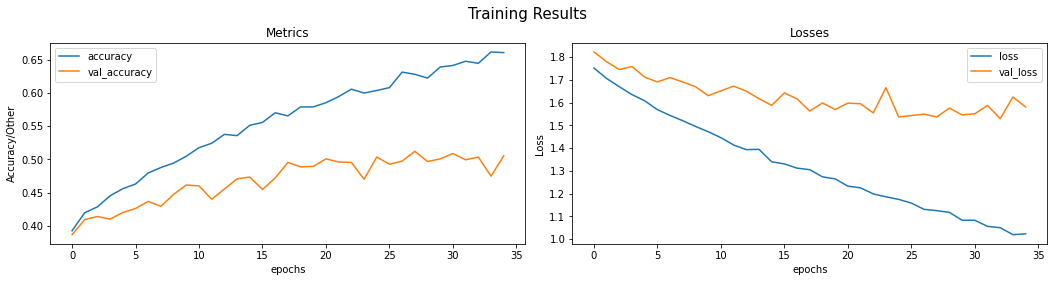

In [ ]:
model_1,history_1 = ContinueTraining(trn_data=train_data,
                                     val_data=valid_data,
                                     model=model_1,
                                     callbacks=None,
                                     epochs=35,
                                     verbose=1)

In [ ]:
model_1.evaluate(test_data)

79/79 [==============================] - 11s 135ms/step - loss: 1.4658 - accuracy: 0.5368


[1.4658416509628296, 0.5368000268936157]

In [ ]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 222, 222, 50)      1400      
                                                                 
 P1 (MaxPooling2D)           (None, 111, 111, 50)      0         
                                                                 
 Conv_2 (Conv2D)             (None, 109, 109, 50)      22550     
                                                                 
 P2 (MaxPooling2D)           (None, 54, 54, 50)        0         
                                                                 
 Conv_3 (Conv2D)             (None, 52, 52, 50)        22550     
                                                                 
 P3 (MaxPooling2D)           (None, 26, 26, 50)        0         
                                                                 
 Flatten_1 (Flatten)         (None, 33800)            

In [ ]:
#--- Save the Model
model_1.save('project3_model_1.h5')

## ⚡ This model was able to predict with **53% accuracy** after only **40 epochs**!

## ❗ The **validation** & **training** losses are **beginning to diverge**. The validation loss has tapered but the training loss has not. Meaning the model will likely begin to **overfit with continued training**.

## 🔑 The Model uses ~5.5 Million **parameters**, which is **comparable** to the simple model but with a 15 basis point increase in accuracy. This is approximately a **40% boost in model performance**.


# 📔 Further improvements may be made using **Transfer Learning**, which will be investigated in other notebooks.  